# COVID-19 Infection curve analysis                                                                      
## Naoaki ONO nono@is.nasit.jp   

CoViD-19 infection curve (in Japan, from Jan. 15, 2020) analysis using R.

The numbers of infected and tested by PCR have been gathered from the website of Ministry of Health, Labour and Welfare, Japan

Sources and data are available on GitHub.
https://github.com/naono-git/covid19

Open using [nbviewer service](https://nbviewer.jupyter.org/github/naono-git/covid19/tree/master/covid19.ipynb)


In [169]:
library(date)
# library(smooth)
source("src/plotUtil.R")

In [170]:
covid <- read.delim("data/covid19.txt", header=TRUE, sep="\t")
nd <- nrow(covid)
stamp <- paste(c(covid[nd,1],sprintf("%02d",covid[nd,2]),sprintf("%02d",covid[nd,3])),collapse="")
stamp

[1] "20200401"

In [171]:
ddd <- mdy.date(month=covid$mm, day=covid$dd, year=covid$yy)
d0  <- ddd[1]
dd1 <- ddd-d0 ## relative date starting from 2020/01/15                                                   
dd1[1] <- 7   ## initial offset (aribtrary chosen) 

In [172]:
## dates to plot ticks                                                                                    
mdlabel <- rbind(c(1,15),
                 c(2, 1),
                 c(2,15),
                 c(3, 1),
                 c(3,15),
                 c(4, 1),
                 c(4,15),
                 c(5, 1),
                 c(5,15),
                 c(6, 1)
                )
ddlabel <- apply(mdlabel,1,function(xx){
    mdy.date(xx[1],xx[2],2020)
})
## label to plot ticks                                                                                    
ticklabel <- apply(mdlabel,1,paste,collapse="/")

In [173]:
logd <- log(dd1)        ## log day
logi <- log(covid$i)    ## log number of infected                                                               
logp <- log(covid$PCR)  ## log number of PCR

In [174]:
daydiff <- function(xx){
    return(xx - c(0,xx[-length(xx)]))
}
pred_pow <- function(xx,cc,ll){
    return(xx^ll*exp(cc))
}
pred_exp <- function(xx,cc,ll){
    return(cc*exp(ll*xx))
}

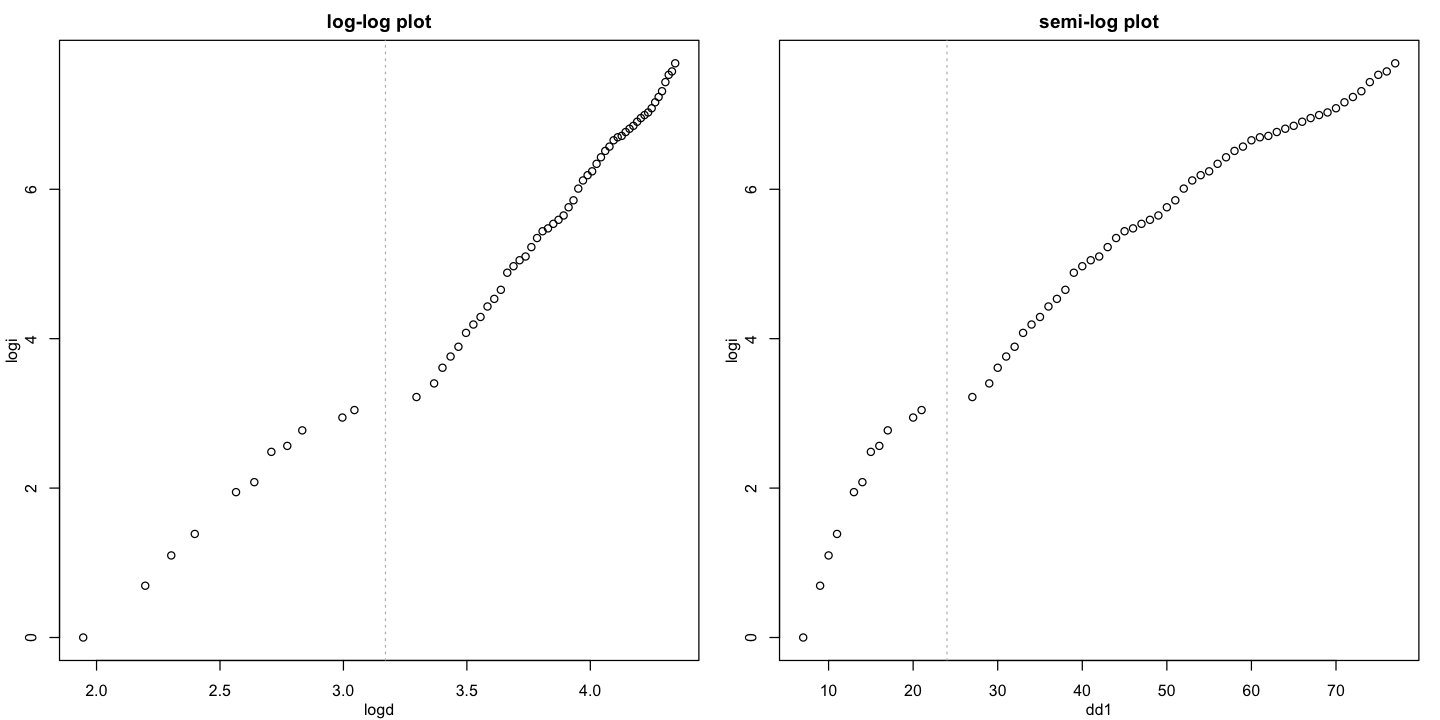

In [175]:
options(repr.plot.width=12, repr.plot.height=6)
par(mfcol=c(1,2))
par.margin("smart")

plot(logd, logi, main="log-log plot")
abline(v=mean(logd[11:12]), lty=3, col=8)
# abline(-2,2,lty=3, col=2)

plot(dd1, logi, main="semi-log plot")
abline(v=mean(dd1[11:12]), lty=3, col=8)
## ... Do you think which looks more linearly?

In [176]:
## Fitting by power. 1, fit for the earlier stage                                                   
model_pow_0 <- lm(logi~logd)
model_pow_0

model_pow_1 <- lm(logi[1:11]~logd[1:11])
model_pow_1

## Fitting by power. 2, fit for the latter stage                                                   
model_pow_2 <- lm(logi[12:nd]~logd[12:nd])
model_pow_2


Call:
lm(formula = logi ~ logd)

Coefficients:
(Intercept)         logd  
     -6.556        3.176  



Call:
lm(formula = logi[1:11] ~ logd[1:11])

Coefficients:
(Intercept)   logd[1:11]  
     -5.562        2.894  



Call:
lm(formula = logi[12:nd] ~ logd[12:nd])

Coefficients:
(Intercept)  logd[12:nd]  
    -10.486        4.164  


In general, the dynamics of infection is described by the "SIR" model.
$$
\frac{dS}{dt} = -\beta IS \\
\frac{dI}{dt} = \beta IS - \gamma I \\
\frac{dR}{dt} = \gamma I,
$$
where S denotes the population ratio of susceptible, I denotes infected, R denotes recoverd, respectively, and $\beta$ and $\gamma$ are the coefficient of infection and recovery.

Where the growth looks linear in the semi-log prot, we can expect the simplest growth dynamics,

$$
\frac{dI}{dt} = \lambda I \\
I(t) = I_0 \exp(\lambda t) \\
\log(I) = \lambda t + C_0
$$



In [177]:
## We focus on the latter growth (D > Feb. 11th)
model_exp_2 <- lm(logi[12:nd]~dd1[12:nd])
model_exp_2
cc_exp_2 <- exp(model_exp_2$coefficients[1])
ll_exp_2 <- model_exp_2$coefficients[2]


Call:
lm(formula = logi[12:nd] ~ dd1[12:nd])

Coefficients:
(Intercept)   dd1[12:nd]  
    1.46584      0.08325  


COVID19_infection_curve_semilog_20200401.jpg 


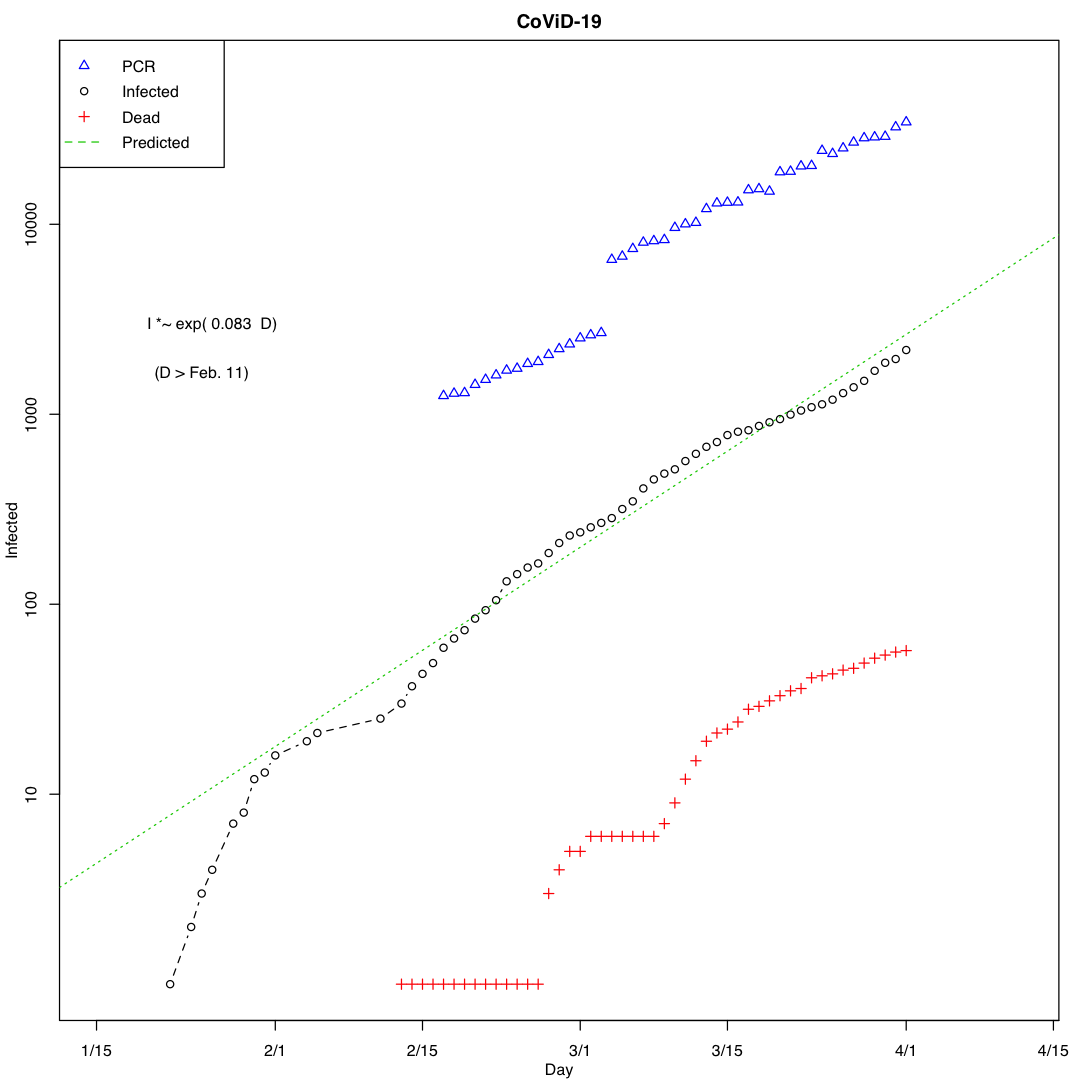

In [178]:
options(repr.plot.width=9, repr.plot.height=9)

file_plot1 <- paste("COVID19_infection_curve_semilog",stamp,sep="_")

plotFigure(function(){
    plot(dd1, logi, axes=FALSE, frame=TRUE, type="b", lty=2,
         xlim=c(0,88),ylim=c(0,11), xlab="Day", ylab="Infected", main="CoViD-19")
    points(dd1, logp, pch=2, col=4)
    points(dd1, log(covid$d), pch=3, col=2)
    axis(1,at=ddlabel-d0,labels=ticklabel)
    axis(2,at=log(c(10^(1:5))),labels=c(10^(1:5)))

    legend("topleft",lty=c(0,0,0,2),pch=c(2,1,3,NA),col=c(4,1,2,3),legend=c("PCR","Infected","Dead","Predicted"))
    # text(10,8,TeX(paste("$I \\propto exp(",round(ll_exp_2,3)," D)$")))
    text(11,8,paste("I *~ exp(",round(ll_exp_2,3)," D)"))
    text(10,7.4,"(D > Feb. 11)")

    abline(model_exp_2, lty=3, col=3)
},rr=1.5,dir="fig",file=file_plot1,dev=c("x11","jpg"))

### Daily increments

In [179]:
pcr_daily <- daydiff(covid$PCR)
inf_daily <- daydiff(covid$i)
daily1 <- cbind(covid[,2:3],inf_daily,pcr_daily)[-1,]

In [183]:
ddlabel-d0
ticklabel
hoge <- cbind(inf_daily,pcr_daily-inf_daily) [-1,]
dim(hoge)
# barplot(rbind(inf_daily,pcr_daily-inf_daily),space=0,ylim=c(0,100), ylab="Num")
#axis(1, at=ddlabel-d0-3, ddlabel-d0)
# axis(1, at=ddlabel-d0-16.5, ticklabel)

[1]   0  17  31  46  60  77  91 107 121 138

[1] "1/15" "2/1"  "2/15" "3/1"  "3/15" "4/1"  "4/15" "5/1"  "5/15" "6/1"

[1] 60  2

COVID19_infection_daily_20200401.jpg 


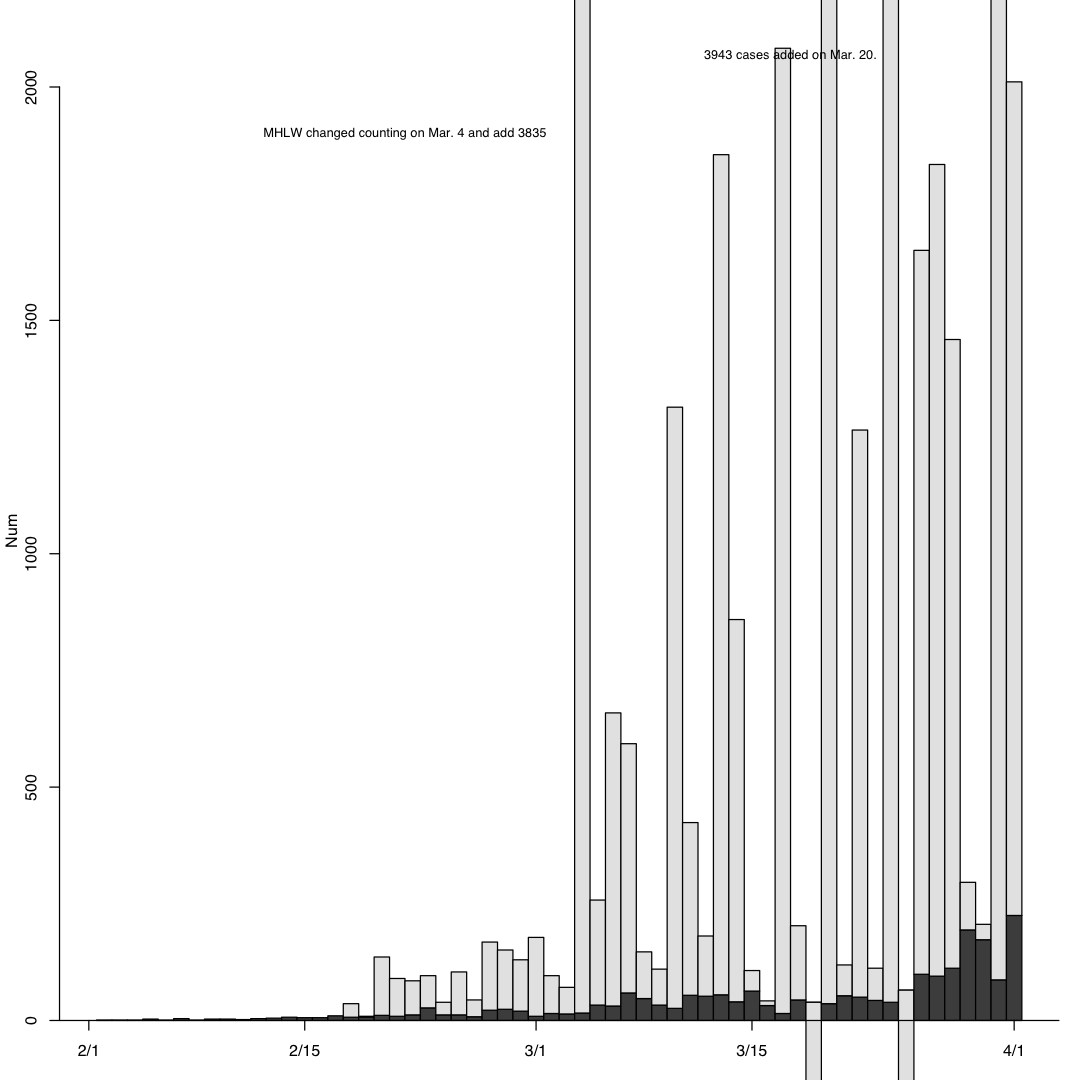

In [184]:
file_plot2 <- paste("COVID19_infection_daily", stamp, sep="_")
hoge <- rbind(inf_daily,pcr_daily-inf_daily) [,-1]

plotFigure(function(){
    barplot(hoge, width=1, space=0, ylim=c(0,2100), ylab="Num")
    axis(1, at=ddlabel-d0-17.5, ticklabel)
    text(20,1900, "MHLW changed counting on Mar. 4 and add 3835",cex=0.8)
    text(45,2070, "3943 cases added on Mar. 20.",cex=0.8)
},rr=1.5, dir="fig",file=file_plot2,dev=c("jpg","x11"))

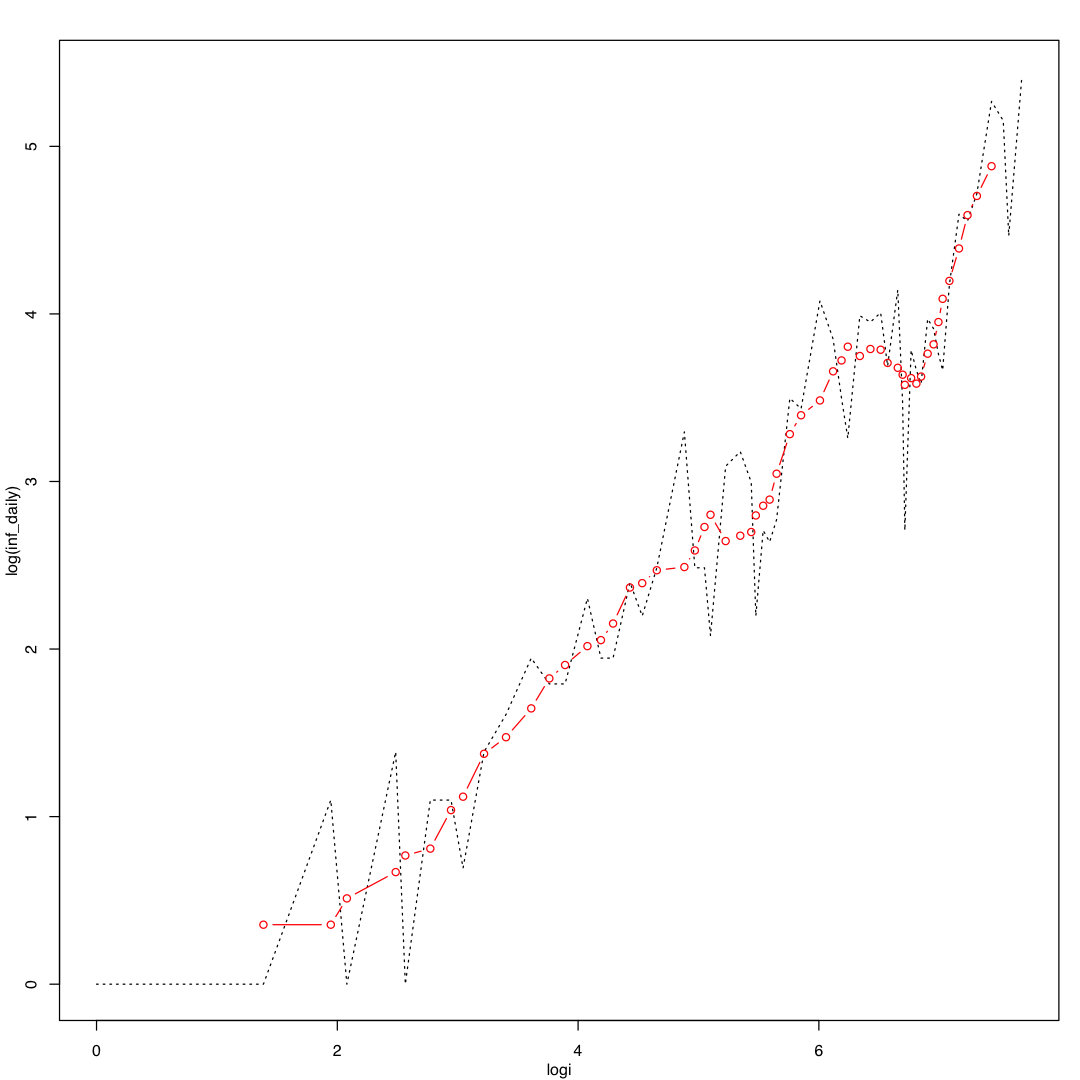

In [185]:
hoge <- filter(log(inf_daily), rep(1/7,7))

plotFigure(function(){
    plot(logi, log(inf_daily), type="l", lty=3)
    points(logi,hoge, type="b", col=2)    
},rr=1)


In [186]:
# prediction of number of infected
pred_exp_2 <- cbind(mdlabel, round(pred_exp(ddlabel-d0, cc_exp_2, ll_exp_2)))[-1,]
colnames(pred_exp_2) <- c("MM","DD","Predcted")
print(pred_exp_2)

      MM DD Predcted
 [1,]  2  1       18
 [2,]  2 15       57
 [3,]  3  1      199
 [4,]  3 15      640
 [5,]  4  1     2633
 [6,]  4 15     8447
 [7,]  5  1    32001
 [8,]  5 15   102644
 [9,]  6  1   422633


### Doubling days and 10 fold days

In [187]:
exp(ll_exp_2[[1]])
log(2)/ll_exp_2[[1]]
log(10)/ll_exp_2[[1]]

[1] 1.086813

[1] 8.32615

[1] 27.65887

### Changes of the slope

In [188]:
## running slope fitting for recent 14 days
ll_exp_d7 <- sapply((11+6):nd, function(di){
    dtmp <- (di-6):di
    model_exp_tmp <- lm(logi[dtmp]~dd1[dtmp])
    return(model_exp_tmp$coefficients[[2]])
})

ll_exp_d15 <- sapply((11+14):nd, function(di){
    dtmp <- (di-14):di
    model_exp_tmp <- lm(logi[dtmp]~dd1[dtmp])
    return(model_exp_tmp$coefficients[[2]])
})
tail(round(ll_exp_d15,4))

[1] 0.0478 0.0491 0.0522 0.0571 0.0611 0.0653

COVID19_lambda_20200401.jpg 


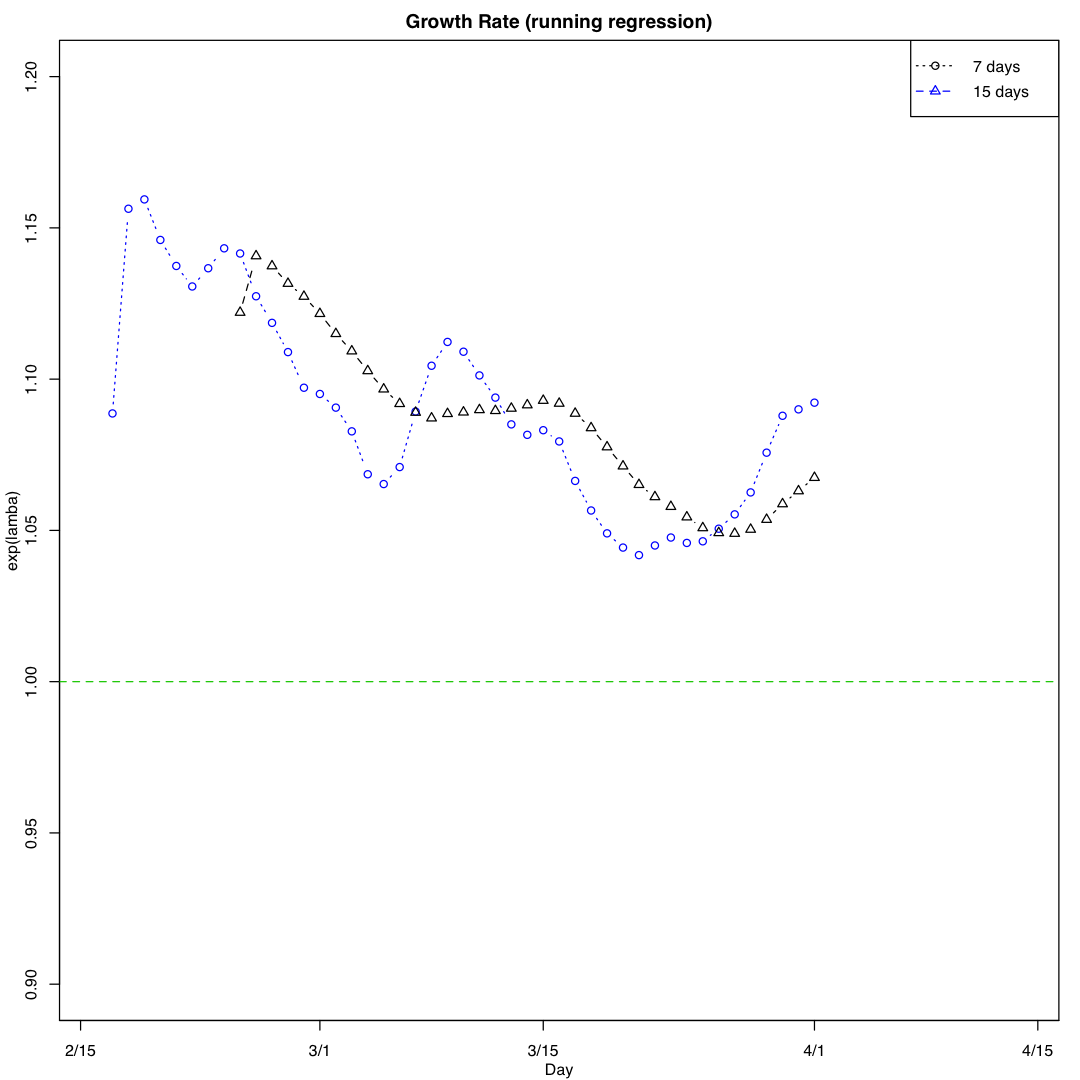

In [191]:
# We are expecting the growth become slower as it comes to saturation level.

file_plot2 <- paste("COVID19_lambda",stamp,sep="_")

plotFigure(function(){
    plot(dd1[(11+6):nd],exp(ll_exp_d7),type="b", xlim=c(32,90), ylim=c(0.9,1.2),lty=3,col=4,
         axes=FALSE, frame=TRUE, main="Growth Rate (running regression)", xlab="Day", ylab="exp(lamba)")
    points(dd1[(11+14):nd],exp(ll_exp_d15),type="b", pch=2,lty=2)
    legend("topright",legend=c("7 days","15 days"), lty=c(3,2), col=c(1,4), pch=c(1,2))
    axis(1,at=ddlabel-d0,labels=ticklabel)
    axis(2)
    abline(1,0,lty=2,col=3)
},rr=1.5,dir="fig",file=file_plot2, dev=c("x11", "jpg"))

# But it looks more further.

Note that there are considerable arguments about why the growth rate in Japan is specifically small compared with other countlies where CoViD-19 has spreading, and it makes the figures in Japan somehow doughtful.

It has been pointed out that Japanese gov. restricted PCR test for only severe cases and people contacted with them, so that the most of lattent carriers has been ignored.

$$
\frac{dS}{dt} = -\beta I_l S \\
\frac{dI_l}{dt} = \beta I_l S - \gamma I_l - \alpha I_l \\
\frac{dI_s}{dt} = \alpha I_l - \gamma I_s \\
\frac{dR}{dt} = \gamma I_l + \gamma I_s.
$$

When $I_l,I_s \ll S$, we can get
$$
I_l(t) = I_0 e^{(\beta-\gamma-\alpha)t}\\
I_s(t) = I_1 e^{(\beta-\gamma-\alpha)t}
$$

From the studies for China and other countries, we can assume $\beta \simeq 0.667, \gamma \simeq 0.333$ [ref. 1](https://timchurches.github.io/blog/posts/2020-02-18-analysing-covid-19-2019-ncov-outbreak-data-with-r-part-1/)

Since the observed growth rate was  $0.104$, we expect that $\alpha \simeq 0.23$. Well, it seems still somehow dubious ......

In [118]:
system("open fig")